In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc
import csv
import os
import sys
import json
from sklearn.linear_model import LinearRegression

In [2]:
def read_json(id, start_date):
  # json파일 불러오기
  with open (f"{id}_{start_date}.json", "r") as f:
      plot_data = json.load(f)

  # 기본 정보 추출
  base_info = {
      'id': int(plot_data['id']),
      'name': plot_data['name'],
      'gender': int(plot_data['gender']),
      'age': int(plot_data['age'])
  }

  # 날짜별 점수 추출
  score_dict = {entry['date']: entry['score'] for entry in plot_data['score_changes']}

  # 병합
  full_row = {**base_info, **score_dict}

  # 데이터프레임 생성
  plot_df = pd.DataFrame([full_row])

  return plot_df

In [ ]:
def draw_graph(id, start_date):

  df = read_json(id, start_date)
  gender = df['gender'][0]
  age = df['age'][0]
  name = df['name'][0]

  # score로 시작하는 컬럼만 추출
  score_cols = [col for col in df.columns if col.startswith("20")]
  score_values = df[score_cols].iloc[0]  # 첫 번째 행 기준 점수들
  
  font_path = 'ex_data/gulim.ttc'
  font_name = font_manager.FontProperties(fname=font_path).get_name()
  matplotlib.rc('font',family=font_name)

  # 배경 색상 (구간 나누기)
  plt.axhspan(0, 50, facecolor='green', alpha=0.1, label='정상 (0~50)')
  plt.axhspan(50, 75, facecolor='yellow', alpha=0.1, label='경도 (50~75)')
  plt.axhspan(75, 100, facecolor='red', alpha=0.1, label='중증 (75~100)')

  # 그래프 그리기
  plt.ylim(0, 100)
  plt.yticks([0, 50, 75, 100], ['0', '50', '75', '100'])
  plt.xticks

  plt.plot(score_cols, score_values, marker='o')
  plt.title(f"인지 기능 (이름:{name}, 나이:{age})")
  plt.xlabel("날짜")
  plt.ylabel("점수")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

findfont: Font family 'Gulim' not found.
findfont: Font family 'Gulim' not found.
findfont: Font family 'Gulim' not found.
findfont: Font family 'Gulim' not found.
findfont: Font family 'Gulim' not found.
findfont: Font family 'Gulim' not found.
findfont: Font family 'Gulim' not found.
findfont: Font family 'Gulim' not found.
findfont: Font family 'Gulim' not found.
/var/folders/s3/6dlfc37j6vscfkx18rs0sw6m0000gn/T/ipykernel_2849/1898740041.py:33: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/s3/6dlfc37j6vscfkx18rs0sw6m0000gn/T/ipykernel_2849/1898740041.py:33: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'Gulim' not found.
findfont: Font family 'Gulim' not found.
findfont: Font family 'Gulim' not found.
findfont: Font family 'Gulim' not found.
findfont: Font family 'Gulim' not found.
/var/folders/s3/6dlfc37j6vscfkx18rs0sw6m0000gn/T/i

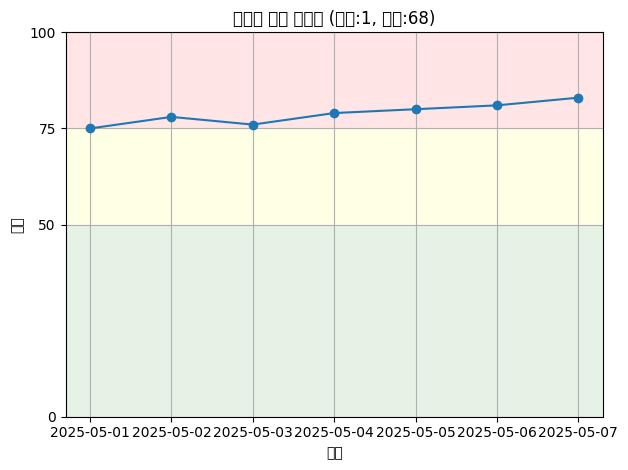

In [6]:
draw_graph('00000000', '2025-05-01')

In [18]:
def get_trend_slope(scores):
    X = np.arange(len(scores)).reshape(-1, 1)  # [[0], [1], ..., [6]]
    y = scores.values.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    return model.coef_[0][0]  # 기울기 반환

In [27]:
def print_report(df):
    score_df = df.drop(labels=['id', 'name', 'gender', 'age'], axis=1)
    # 점수의 평균 계산
    avg_score = ((score_df.sum(axis=1))/len(score_df.columns))[0]
    # 출력되는 문자열 정의
    print_report_str = ''

    # 평균 점수 확인
    if 0<= avg_score < 50:
        print_report_str += '인지 점수의 평균이 \'정상\'에 해당됩니다.\n'
    elif 50 <= avg_score <75:
        print_report_str += '인지 점수의 평균이 \'경도인지장애(MCI)\'에 해당됩니다.\n'
    elif 75 <= avg_score <100:
        print_report_str += '인지 점수의 평균이 \'치매(AD)\'에 해당됩니다. 병원에 방문하여 정확한 진단을 받으시길 권장드립니다.\n'
    else:
        print('평균 점수 오류')
        
    # 추세 확인 (선형 회귀)
    trend_df = df.copy()

    # trend_slope 열 추가
    trend_df['trend_slope'] = score_df.apply(get_trend_slope, axis=1)

    # 기울기 변화의 임계값(기울기가 +- 0.5일 경우 '유지'로 측정)
    score_trend_threshold = 0.5
    # 기울기를 바탕으로 상승/감소 판단
    trend_df['trend'] = trend_df['trend_slope'].apply(
        lambda x: '상승' if score_trend_threshold > 0 else ('감소' if score_trend_threshold < 0 else '유지')
    )
    trend_score = (trend_df['trend'])[0]


    if trend_score == '상승':
        print_report_str += '점수의 변화가 \'상승\'으로 판단됩니다. 인지∙언어 기능 유지를 위하여 규칙적으로 뇌 활동을 자극하고, 꾸준한 신체 활동이 필요합니다.\n'
    elif trend_score == '감소':
        print_report_str += '점수의 변화가 \'감소\'로 판단됩니다. 인지∙언어 기능이 좋아지고 있습니다. \n'
    elif trend_score == '유지':
        print_report_str += '점수의 변화가 \'유지\'로 판단됩니다. 앞으로도 규칙적인 뇌 활동과 신체 활동을 해주세요. \n'
    else:
        print('trend_score 오류')

    return print_report_str


In [28]:
plot_df = read_json('00000000', '2025-05-01')
print_report(plot_df)

"인지 점수의 평균이 '치매(AD)'에 해당됩니다. 병원에 방문하여 정확한 진단을 받으시길 권장드립니다.\n점수의 변화가 '상승'으로 판단됩니다. 인지∙언어 기능 유지를 위하여 규칙적으로 뇌 활동을 자극하고, 꾸준한 신체 활동이 필요합니다.\n"